# Course Completion Prediction

**Latar Belakang**

Seiring dengan meningkatnya popularitas pendidikan online, institusi pendidikan dan platform e-learning mencari cara untuk meningkatkan tingkat penyelesaian kursus. Banyak peserta kursus online mengalami kesulitan untuk menyelesaikan kursus yang mereka ikuti, yang dapat disebabkan oleh berbagai faktor seperti motivasi, waktu, dan kesulitan materi. Mengetahui faktor-faktor yang mempengaruhi penyelesaian kursus dan dapat memprediksi peserta mana yang kemungkinan besar tidak akan menyelesaikan kursus sangat penting untuk merancang intervensi yang efektif.

**Tujuan Proyek**

Proyek ini bertujuan untuk membangun model machine learning yang dapat memprediksi apakah seorang peserta akan menyelesaikan kursus atau tidak berdasarkan berbagai fitur yang relevan. Dengan prediksi ini, platform e-learning dapat mengambil langkah proaktif untuk meningkatkan tingkat penyelesaian kursus, seperti memberikan dukungan tambahan kepada peserta yang berisiko.

**Business Understanding**

1. **Signifikansi Bisnis**

    Tingkat penyelesaian kursus yang rendah dapat mempengaruhi reputasi dan keberlanjutan platform e-learning. Dengan meningkatkan tingkat penyelesaian, platform dapat meningkatkan kepuasan dan retensi peserta, yang pada gilirannya dapat meningkatkan jumlah pendaftaran kursus dan pendapatan. Selain itu, peserta yang menyelesaikan kursus lebih cenderung merekomendasikan platform kepada orang lain, menciptakan efek word-of-mouth yang positif.

2. **Pemangku Kepentingan**

    Pemangku kepentingan utama dalam proyek ini meliputi:
    - Manajemen platform e-learning
    - Tim pengembangan produk
    - Instruktur dan pembuat konten kursus
    - Peserta kursus

**Data**

Dataset yang digunakan dalam proyek ini diambil dari Kaggle, dengan judul "Predict Online Course Engagement Dataset" yang dapat diakses di [sini](https://www.kaggle.com/datasets/rabieelkharoua/predict-online-course-engagement-dataset). Pada dataset tersebut terdapat 9000 baris dan 9 kolom, dengan kolom sebagai berikut:
- `UserID`: Identifikasi unik untuk setiap pengguna.
- `CourseCategory`: Kategori kursus yang diambil.
- `TimeSpentOnCourse`: Waktu yang dihabiskan peserta pada kursus dalam jam.
- `NumberOfVideosWatched`: Jumlah video yang ditonton oleh peserta.
- `NumberOfQuizzesTaken`: Jumlah kuis yang diambil oleh peserta.
- `QuizScores`: Rata-rata skor yang diperoleh peserta dari kuis.
- `CompletionRate`: Tingkat penyelesaian materi kursus.
- `DeviceType`: Jenis perangkat yang digunakan peserta untuk mengakses kursus (Dekstop (0) or Mobile (1)).
- `CourseCompletion`: Apakah peserta menyelesaikan kursus atau tidak (label target).


## Import libraries

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import json

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    roc_auc_score,
    confusion_matrix,
)

plt.style.use("ggplot")

In [5]:
RAW_DATA_PATH = "../data/raw/online_course_engagement_data.csv"

def load_course_completion(path):
    return pd.read_csv(path)

# Load the data 
df = load_course_completion(RAW_DATA_PATH)

In [9]:
df.head()

,UserID,CourseCategory,TimeSpentOnCourse,NumberOfVideosWatched,NumberOfQuizzesTaken,QuizScores,CompletionRate,DeviceType,CourseCompletion
0,5618,Health,29.979719,17,3,50.365656,20.860773,1,0
1,4326,Arts,27.802640,1,5,62.615970,65.632415,1,0
2,5849,Arts,86.820485,14,2,78.458962,63.812007,1,1
3,4992,Science,35.038427,17,10,59.198853,95.433162,0,1
4,3866,Programming,92.490647,16,0,98.428285,18.102478,0,0


## Exploratory Data Analysis (EDA)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   UserID                 9000 non-null   int64  
 1   CourseCategory         9000 non-null   object 
 2   TimeSpentOnCourse      9000 non-null   float64
 3   NumberOfVideosWatched  9000 non-null   int64  
 4   NumberOfQuizzesTaken   9000 non-null   int64  
 5   QuizScores             9000 non-null   float64
 6   CompletionRate         9000 non-null   float64
 7   DeviceType             9000 non-null   int64  
 8   CourseCompletion       9000 non-null   int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 632.9+ KB


- Terdapat 9000 baris dalam dataset dengan 9 kolom/fitur
- Terdapat 1 fitur dengan tipe data object yaitu `CourseCategory`
- Terdapat 5 fitur dengan tipe data int (bilangan bulat) yaitu `UserID`, `TimeSpentOnCourse`, `NumberOfVideosWatched`, `NumberOfQuizzesTaken`, `DeviceType`, dan `CourseCompletion` (fitur target)
- Terdapat 3 fitur dengan tipe data float yaitu `TimeSpentOnCourse`, `QuizScores`, dan `CompletionRate`
- Tidak ada nilai `null`

In [13]:
# Check data duplicated
print(f"The number of data duplicated is {df.duplicated().sum()} data")

The number of data duplicated is 877 data


In [14]:
# Drop data duplicated
df = df.drop_duplicates().reset_index(drop=True)

In [16]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
UserID,8123.0,4504.687185,2604.220672,1.000000,2248.500000,4492.000000,6766.500000,9000.000000
TimeSpentOnCourse,8123.0,50.607728,28.364184,1.005230,26.114631,50.316921,75.377730,99.992558
NumberOfVideosWatched,8123.0,10.148098,5.987972,0.000000,5.000000,10.000000,15.000000,20.000000
NumberOfQuizzesTaken,8123.0,5.166933,3.132108,0.000000,2.000000,5.000000,8.000000,10.000000
QuizScores,8123.0,75.091084,14.339876,50.005119,62.791226,75.273913,87.497542,99.994984
CompletionRate,8123.0,51.190873,29.069716,0.009327,26.276765,51.581186,76.729629,99.979711
DeviceType,8123.0,0.500431,0.500031,0.000000,0.000000,1.000000,1.000000,1.000000
CourseCompletion,8123.0,0.439247,0.496326,0.000000,0.000000,0.000000,1.000000,1.000000


- Waktu (`TimeSpentOnCourse`): Rata-rata user menghabiskan waktu untuk menyelesaikan course sekitar 50 jam dengan nilai minimum 1 jam dan maksimum 99.99 (100) jam.
- Video (`NumberOfVideosWatched`): Rata-rata user menonton sebanyak 10 video dengan minimum 0 video dan maksimum 20 video.
- Kuis (`NumberOfQuizzesTaken`): Rata-rata user mengerjakan sebanyak 5 kuis dengan minimum 0 kuis dan maksimum 10 kuis.
- Skor Kuis (`QuizScores`): Rata-rata user mendapatkan skor kuis 75.
- Tingkat Penyelesaian (`CompletionRate`): Rata-rata user memiliki tingkat penyelesaian sebesar 51%.
- Device: Terdapat dua nilai yaitu 0 untuk pengguna Dekstop dan 1 untuk pengguna Mobile dengan proporsi masing-masing hampir 50%.
- `CourseCompletion`: Terdapat dua nilai yaitu 0 untuk yang tidak menyelesaikan course dan 1 untuk yang menyelesaikan course dengan proporsi sekitar 44% menyelesaikan course.

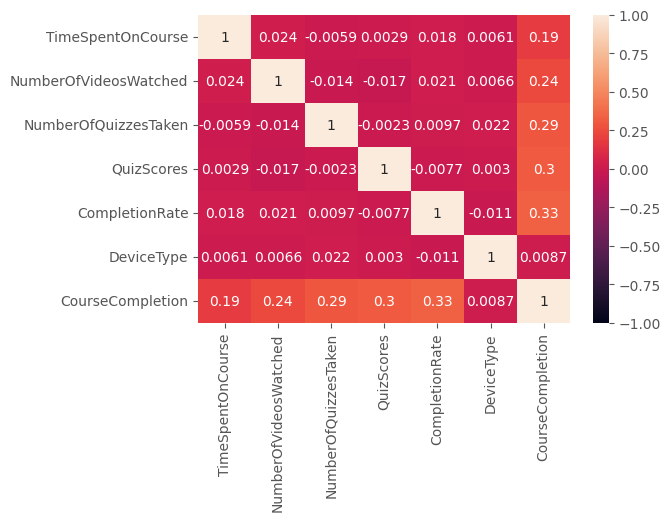

In [20]:
# Correlation
plt.figure(figsize=(6, 4))
sns.heatmap(df.corr(numeric_only=True), annot=True, vmin=-1, vmax=1)
plt.show()

Top 5 korelasi dengan fitur target (`CourseCompletion`):
- `CompletionRate` (0.33)
- `QuizScores` (0.3)
- `NumberOfQuizzesTaken` (0.29)
- `NumberOfVideosWatched` (0.24)
- `TimeSpentOnCourse` (0.19)

Tidak ada fitur yang memiliki korelasi secara signifikan dengan fitur target

### Univariate Analysis

In [17]:
# Drop UserID column (to make it easier to analyze)
df = df.drop(columns="UserID", axis=1)

#### Numeric

**Asumsi**: `DeviceType` dan `CourseCompletion` dianggap categorical column karena hanya memiliki dua nilai klasifikasi

In [21]:
num_cols = [
    "TimeSpentOnCourse",
    "NumberOfVideosWatched",
    "NumberOfQuizzesTaken",
    "QuizScores",
    "CompletionRate",
]

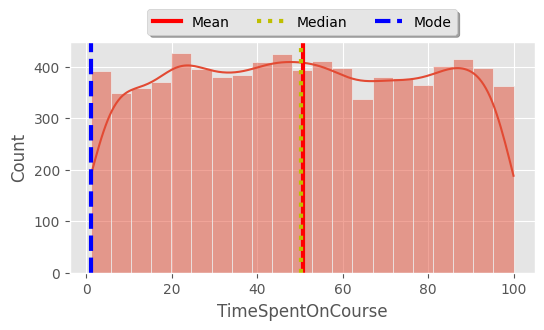

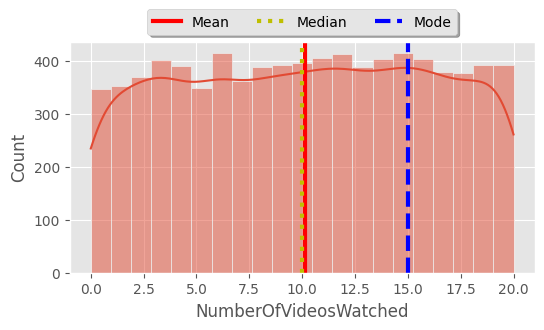

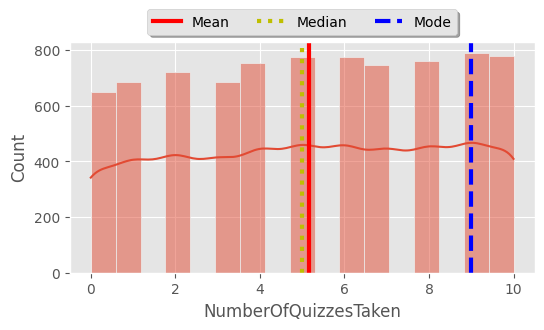

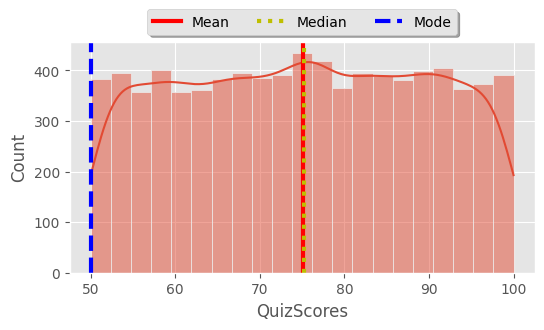

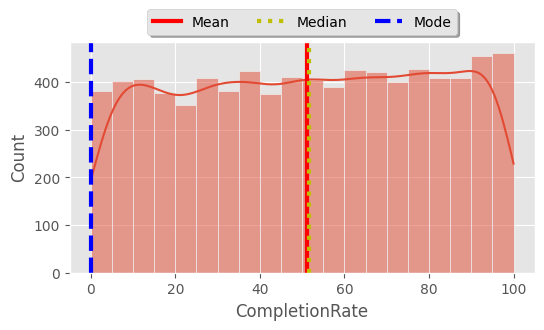

In [22]:
# Distribution of each numeric columns
for col in num_cols:
    # Statistic descriptive
    average = df[col].mean()
    median = df[col].median()
    mode = df[col].mode()[0]
    std = df[col].std()

    # Make subplot for histogram
    fig, ax = plt.subplots(figsize=(6, 3))
    sns.histplot(data=df, x=col, kde=True)
    plt.axvline(average, color="r", linestyle="solid", linewidth=3, label="Mean")
    plt.axvline(median, color="y", linestyle="dotted", linewidth=3, label="Median")
    plt.axvline(mode, color="b", linestyle="dashed", linewidth=3, label="Mode")
    plt.legend(
        loc="upper center",
        ncol=3,
        bbox_to_anchor=(0.5, 1.17),
        fancybox=True,
        shadow=True,
    )
    plt.show()

Distribusi untuk masing-masing fitur numerik memiliki distribusi yang cukup merata, dengan nilai rata-rata (mean) yang selalu berimpit dengan nilali median. Dapat disimpulkan bahwa fitur-fitur numerik memiliki distribusi yang baik.

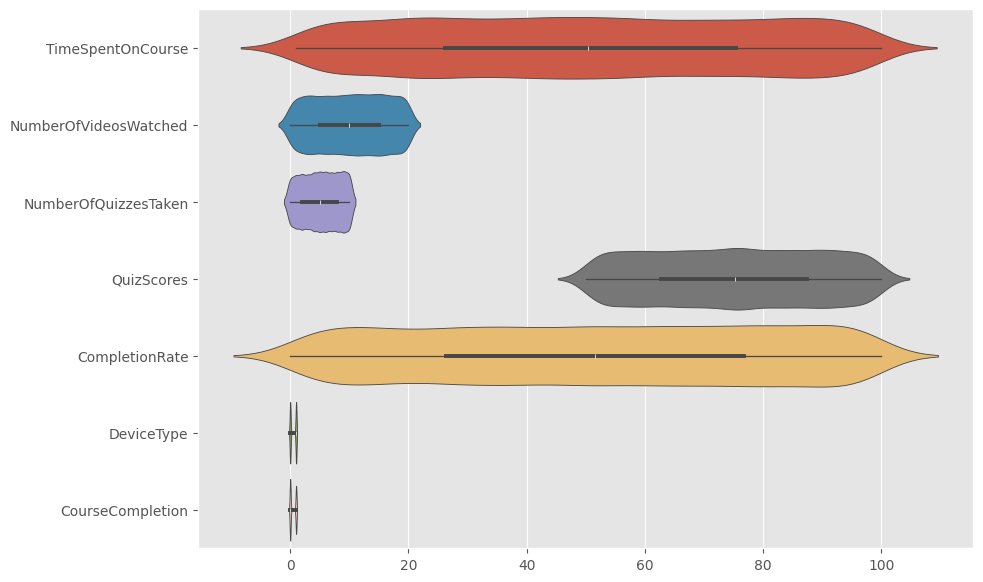

In [23]:
# Violin plot for numeric columns
plt.figure(figsize=(10, 7))
sns.violinplot(data=df, orient="y")
plt.show()

Berdasarkan violinplot tersebut, terlihat bahwa data terdistribusi dengan baik dan tidak memiliki outlier.

#### Categorical

In [24]:
cat_cols = ["CourseCategory", "DeviceType", "CourseCompletion"]

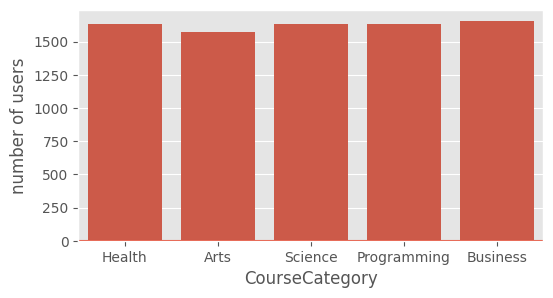

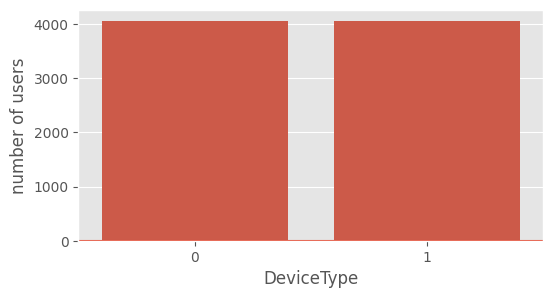

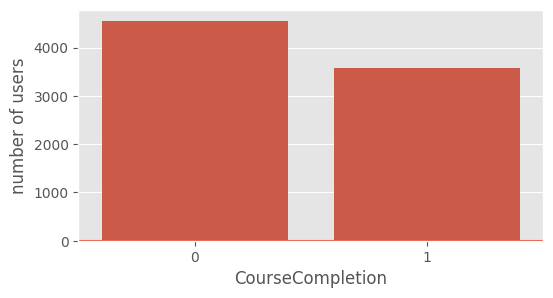

In [25]:
# Barchart plot for categorical columns
for col in cat_cols:
    fig, ax = plt.subplots(figsize=(6, 3))
    sns.countplot(data=df, x=col)
    plt.axhline()
    plt.ylabel("number of users")
    plt.show()

In [30]:
df["CourseCompletion"].value_counts() / len(df)

CourseCompletion
0    0.560753
1    0.439247
Name: count, dtype: float64

Berdasarkan barplot pada fitur-fitur kategorikal tersebut, terlihat bahwa fitur-fitur tersebut memiliki distribusi yang baik. Pada `CourseCategory`, nilai *Arts* menjadi nilai yang paling sedikit, pada `DeviceType` memiliki proporsi nilai dengan selisih sedikit. Sedangkan pada `CourseCompletion` memiliki proporsi sekitar 56.07% untuk nilai 0 dan 43.92% untuk nilai 1.

### Bivariate Analysis

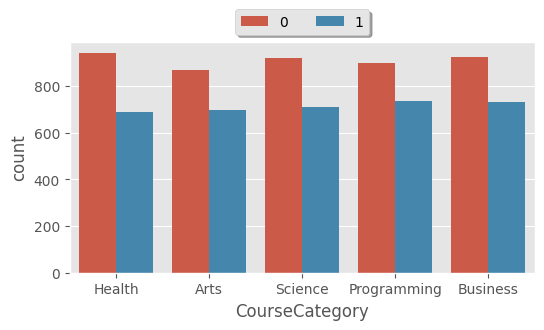

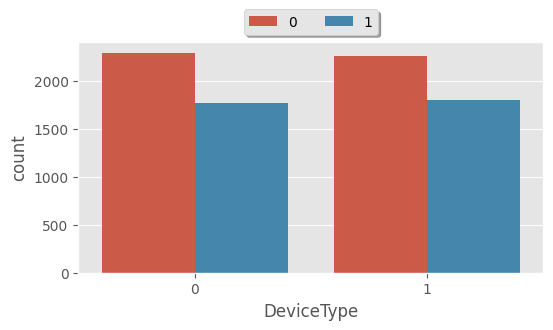

In [31]:
# Number of CourseCategory and DeviceType by CouseCompletion
for col in ["CourseCategory", "DeviceType"]:
    fig, ax = plt.subplots(figsize=(6, 3))
    sns.countplot(data=df, x=col, hue="CourseCompletion")
    plt.legend(
        loc="upper center",
        ncol=2,
        bbox_to_anchor=[0.5, 1.17],
        fancybox=True,
        shadow=True,
    )
    plt.show()

Berdasarkan distribusi di atas, terlihat bahwa proporsi nilai dari `CourseCompletion` hampir sama untuk setiap nilai pada fitur `CourseCategory` dan `DeviceType`. Dapat disimpulkan bahwa nilai pada `CourseCompletion` memenuhi *impurity* untuk fitur-fitur kategorikal.

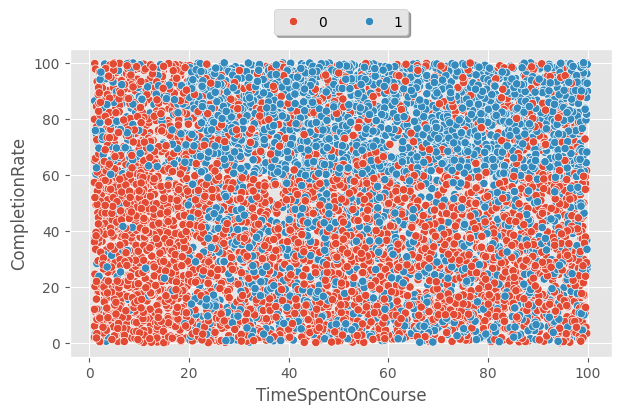

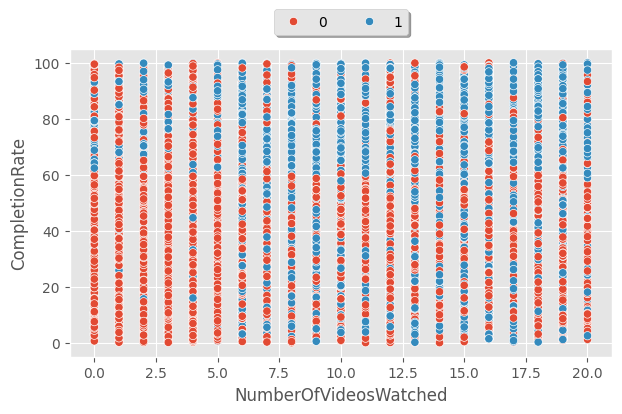

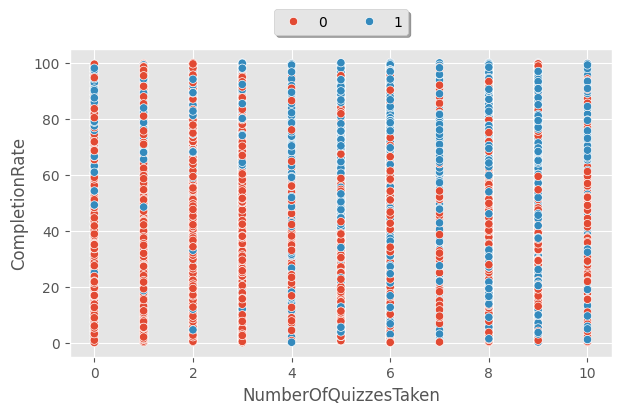

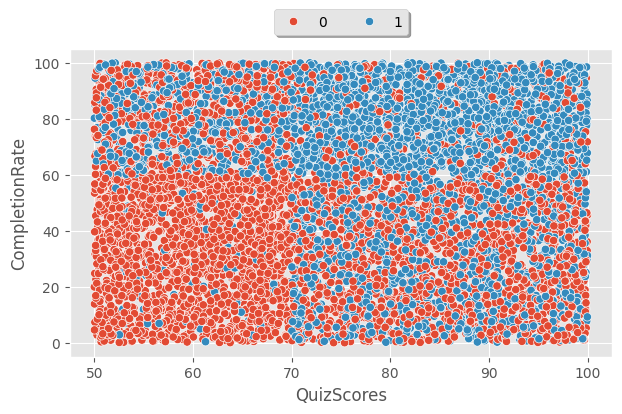

In [34]:
# Relation of 2 numeric column
# numeric columns and CompletionRate column
for col in num_cols:
    if col == "CompletionRate":
        continue

    fig, ax = plt.subplots(figsize=(7, 4))
    sns.scatterplot(data=df, x=col, y="CompletionRate", hue="CourseCompletion")
    plt.legend(
        loc="upper center",
        ncol=2,
        bbox_to_anchor=[0.5, 1.15],
        fancybox=True,
        shadow=True,
    )
    plt.show()

Berdasarkan scatterplot di atas, diperoleh bahwa peluang menyelesaikan course yang tinggi terjadi ketika:
- `CompletionRate` lebih dari 60.
- `TimeSpentOnCourse` lebih dari 20 jam.
- `NumberOfVideosWatched` lebih dari 5.
- `NumberOfQuizzesTaken` lebih dari 4.
- `QuizScores` lebih dari 70.

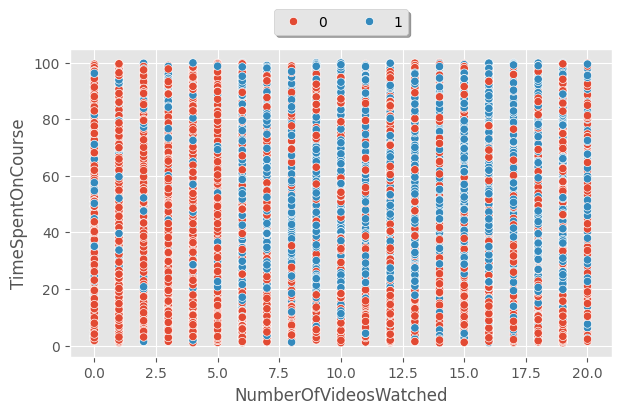

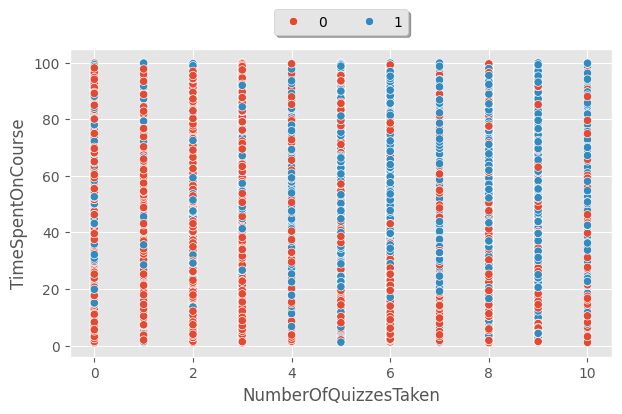

In [35]:
for col in ["NumberOfVideosWatched", "NumberOfQuizzesTaken"]:
    fig, ax = plt.subplots(figsize=(7, 4))
    sns.scatterplot(data=df, x=col, y="TimeSpentOnCourse", hue="CourseCompletion")
    plt.legend(
        loc="upper center",
        ncol=2,
        bbox_to_anchor=[0.5, 1.15],
        fancybox=True,
        shadow=True,
    )
    plt.show()

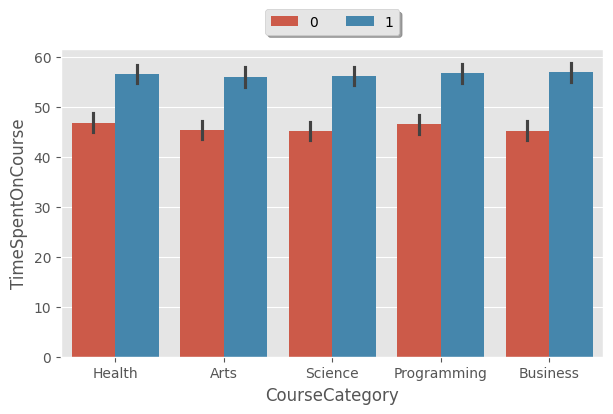

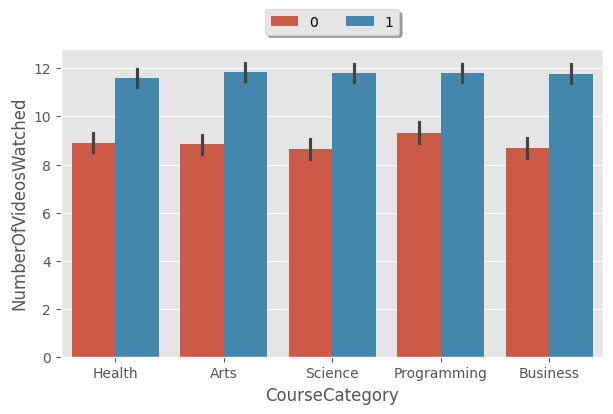

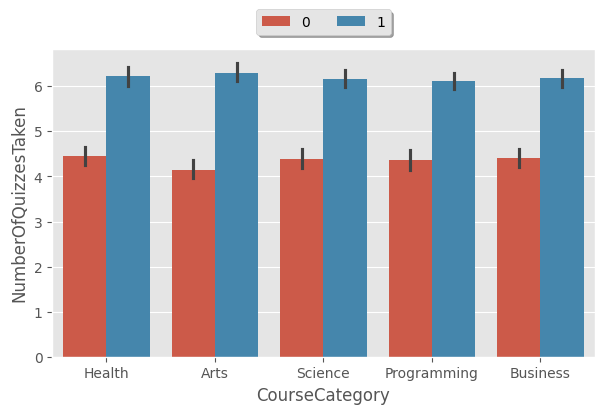

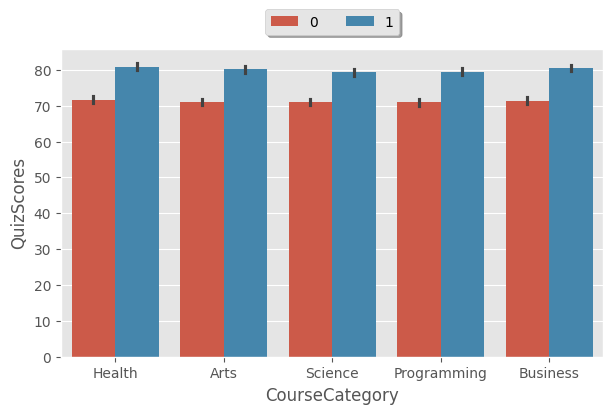

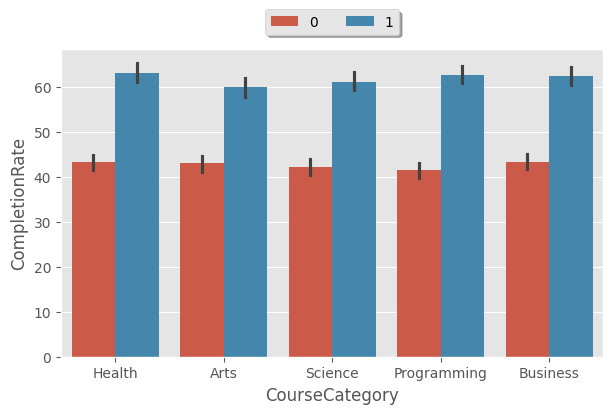

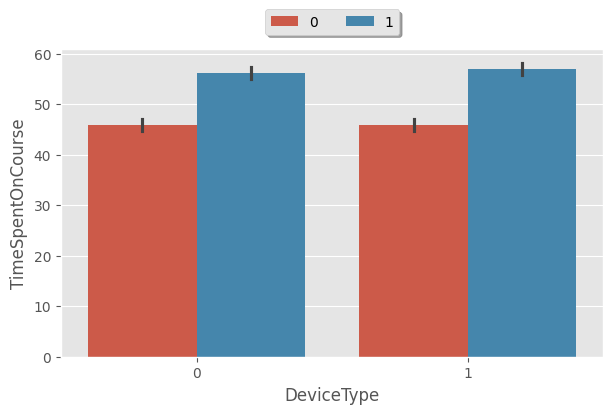

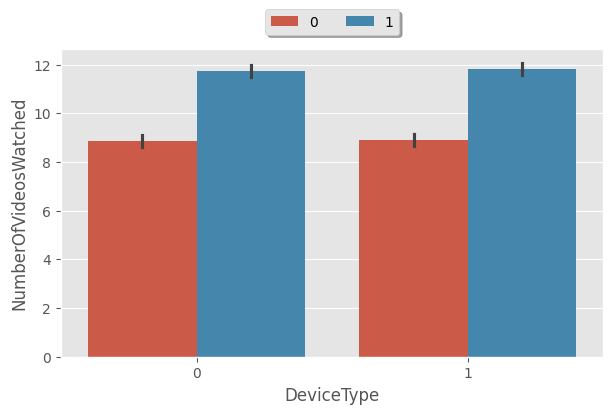

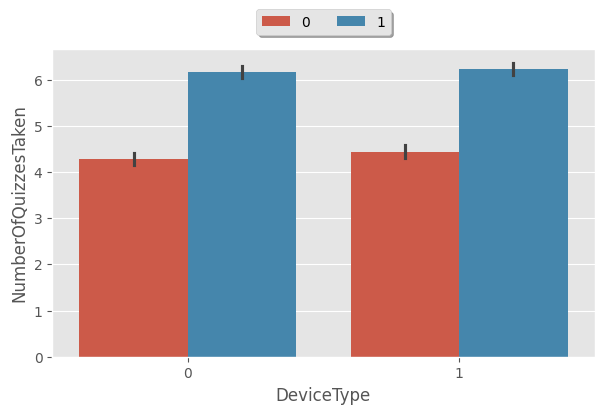

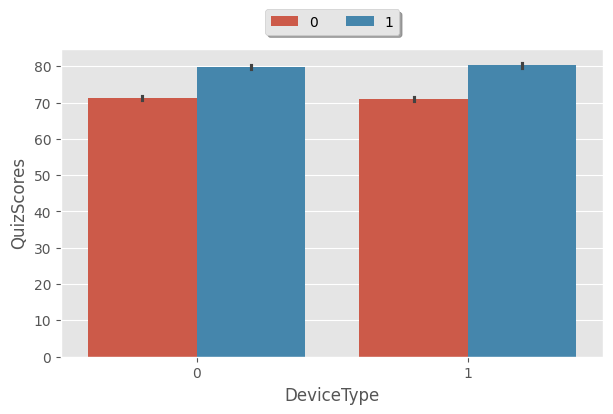

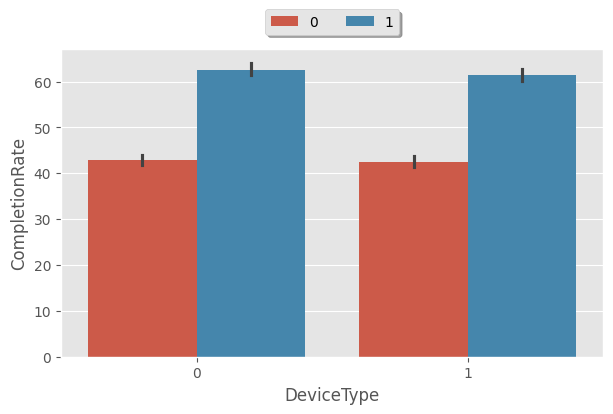

In [36]:
# Numeric columns by categorical columns
for cat_col in cat_cols:
    if cat_col == "CourseCompletion":
        continue

    for num_col in num_cols:
        fig, ax = plt.subplots(figsize=(7, 4))
        sns.barplot(data=df, x=cat_col, y=num_col, hue="CourseCompletion")
        plt.legend(
            loc="upper center",
            ncol=2,
            bbox_to_anchor=[0.5, 1.15],
            fancybox=True,
            shadow=True,
        )
        plt.show()

Berdasarkan distribusi di atas, terlihat bahwa:
- Distribusi fitur-fitur numerik berdasarkan  fitur kategorikal sangat baik, tidak terjadi imbalance
- Proporsi untuk fitur target juga terbagi hampir sama, sehingga dapat disimpulkan bahwa nilai pada `CourseCompletion` juga memenuhi *impurity* untuk fitur-fitur numerik.

### Data Preparation

Pada tahap ini akan dilakukan One Hot Encoding. One hot encoding adalah teknik yang digunakan untuk mengubah data kategorikal menjadi format yang dapat digunakan oleh algoritma machine learning. Teknik ini mengubah setiap kategori menjadi vektor biner yang terdiri dari nilai 0 dan 1. Setiap kategori asli diwakili oleh satu kolom yang memiliki nilai 1 (untuk kategori tersebut) dan 0 untuk kategori lainnya. Teknik ini membantu algoritma machine learning untuk memahami data kategori dengan lebih baik tanpa memberikan bobot numerik yang tidak diinginkan pada kategori.

Pada dataset ini hanya `CourseCategory` yang bertipe kategorikal. Maka fitur tersebut akan diubah menggunakan one hot encoding.

In [38]:
# One Hot Encoding for CourseCategory column
df = pd.get_dummies(df, columns=["CourseCategory"], dtype="int32")

### Modeling

Pada pemodelan machine learning kali ini akan digunakan Logistic Regression, Decision Tree, Random Forest, dan XGBoost sebagai algoritmanya.

- **Logistic Regression:**
    
    Logistic Regression memprediksi hasil biner (dua kelas) dengan menggunakan rumus matematika yang menghitung probabilitas berdasarkan data input. Jika probabilitas di atas 0.5, hasilnya adalah satu kelas; jika di bawah 0.5, hasilnya adalah kelas lainnya.
- **Decision Tree:** 

    Decision Tree memprediksi hasil dengan membuat keputusan berbasis aturan yang terbagi menjadi cabang-cabang. Setiap cabang mewakili keputusan berdasarkan fitur data, dan hasil akhirnya adalah daun yang mewakili prediksi.
- **Random Forest:** 

    Random Forest adalah kumpulan dari banyak Decision Tree. Setiap pohon dalam hutan memberikan prediksinya, dan hasil akhirnya adalah rata-rata dari semua prediksi pohon, yang membuat model lebih akurat dan stabil.
- **XGBoost:** 

    Random Forest adalah kumpulan dari banyak Decision Tree. Setiap pohon dalam hutan memberikan prediksinya, dan hasil akhirnya adalah rata-rata dari semua prediksi pohon, yang membuat model lebih akurat dan stabil.

In [40]:
# Modeling
X = df.drop("CourseCompletion", axis=1)
y = df.CourseCompletion

Modeling kali ini tidak melewati proses standarisasi atau normalisasi data, hal itu karena algoritma yang digunakan kali ini tidak terlalu sensitif terhadap skala fitur kecuali Logistic Regression.

> Note: Disarankan tetap menggunakan standarisasi atau normalisasi, karena dalam beberapa kasus itu akan sangat membantu membangun model yang baik.

In [41]:
# Split data to train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

Dalam proses training model, digunakan `GridSearchCV` untuk menemukan model terbaik. `GridSearchCV` membantu dalam menemukan kombinasi hyperparameter terbaik untuk model machine learning dengan secara sistematis menguji semua kemungkinan parameter dan menggunakan cross-validation untuk memastikan kinerja model yang optimal. Ini mengotomatisasi pencarian parameter, mengurangi risiko overfitting, dan meningkatkan akurasi model dengan memanfaatkan evaluasi yang kuat dan paralelisasi, serta mudah diintegrasikan dengan library seperti `scikit-learn`.

In [42]:
# Make function for training model and evaluate model
def train_model(model, param_grid, cv=5, scoring="roc_auc", n_jobs=-1, verbose=1):
    # Define GridSearchCV
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        scoring=scoring,
        n_jobs=n_jobs,
        verbose=verbose,
    )

    # Fit the model
    grid_search.fit(X_train, y_train)

    # Return best parameters
    return grid_search

Menggunakan akurasi, presisi, recall, dan ROC AUC sebagai metrik evaluasi model memberikan pandangan yang komprehensif tentang kinerja model:

- **Akurasi**: Mengukur seberapa banyak prediksi model yang benar dibandingkan dengan total prediksi, memberikan gambaran umum - tentang kinerja model secara keseluruhan.
- **Presisi**: Mengukur seberapa banyak prediksi positif yang benar dibandingkan dengan total prediksi positif, penting untuk mengurangi false positives.
- **Recall**: Mengukur seberapa banyak kasus positif yang benar-benar teridentifikasi dari total kasus positif, penting untuk mengurangi false negatives.
- **ROC AUC**: Mengukur kemampuan model untuk membedakan antara kelas positif dan negatif, memberikan gambaran tentang performa model di berbagai threshold.

Sedangkan Confusion matrix juga digunakan untuk menunjukkan jumlah prediksi benar dan salah untuk setiap kelas dalam model klasifikasi. Ini membantu memahami kinerja model dengan memperlihatkan berapa banyak kasus yang benar-benar positif, negatif, serta kesalahan (false positives dan false negatives).

In [43]:
# Function to evaluate metrics
def evaluate_metrics(model, X=X_test, y=y_test):
    # Predictions
    y_pred = model.predict(X)
    y_prob = model.predict_proba(X)[:, 1]

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_prob)

    conf_matrix = confusion_matrix(y, y_pred)
    # Plot confusion matrix
    print("\nConfusion Matrix:")
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, precision, recall, roc_auc

In [44]:
# Model
models = {
    "lr": LogisticRegression(solver="liblinear"),
    "dt": DecisionTreeClassifier(),
    "rf": RandomForestClassifier(),
    "xgb": XGBClassifier(),
}

Pada `LogisticRegression` menggunakan solver `liblinear` karena efisien dan cepat. Solver ini cocok untuk masalah klasifikasi biner dan multiclass serta mendukung regularisasi L1 dan L2, membantu mencegah overfitting.

In [45]:
# Define the parameter grid
param_grids = {
    "lr": {"C": np.logspace(-4, 4, 20), "penalty": ["l1", "l2"]},
    "dt": {
        "criterion": ["gini", "entropy"],
        "max_depth": [None, 10, 20, 30, 40, 50],
        "min_samples_split": [2, 10, 20],
        "min_samples_leaf": [1, 5, 10],
    },
    "rf": {
        "n_estimators": [100, 200, 300],
        "max_depth": [None, 10, 20, 30],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "bootstrap": [True, False],
    },
    "xgb": {
        "n_estimators": [100, 200, 300],
        "max_depth": [3, 6, 9],
        "learning_rate": [0.01, 0.1, 0.2],
        "subsample": [0.7, 0.8, 0.9],
        "colsample_bytree": [0.7, 0.8, 0.9],
        "gamma": [0, 0.1, 0.2],
    },
}

Training LogisticRegression(solver='liblinear')...

Confusion Matrix:


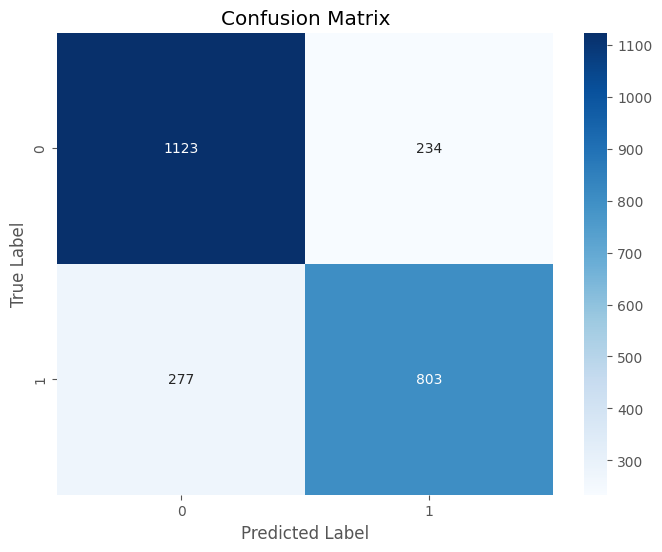

Training DecisionTreeClassifier()...

Confusion Matrix:


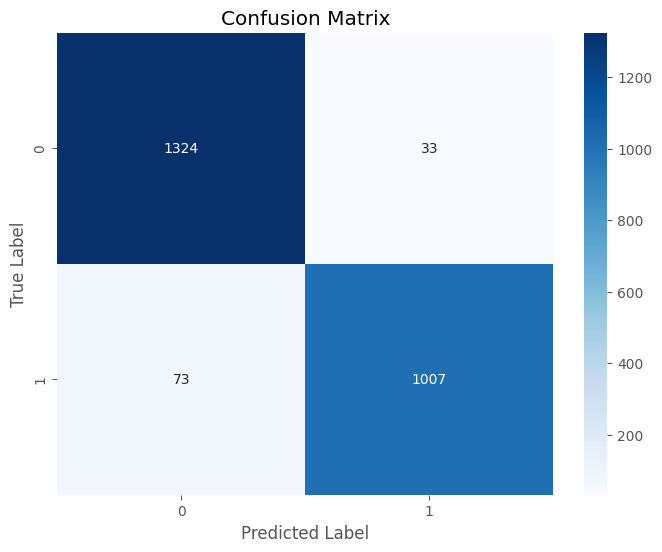

Training RandomForestClassifier()...


d:\Dev\Data Science\Course Completion Prediction\.venv\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,



Confusion Matrix:


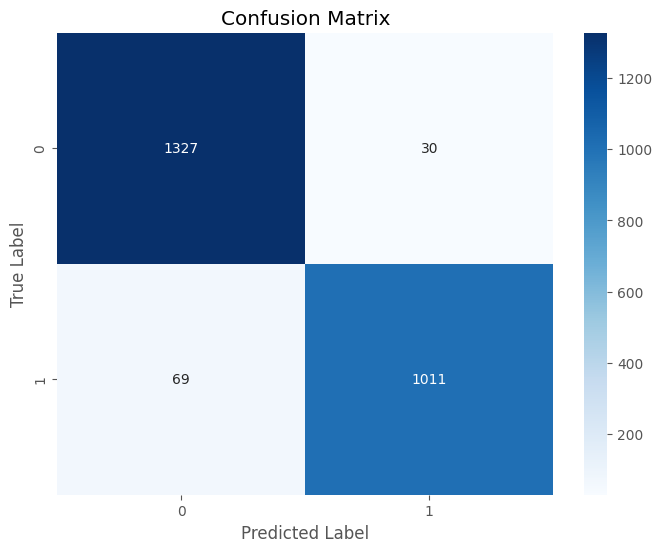

Training XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)...

Confusion Matrix:


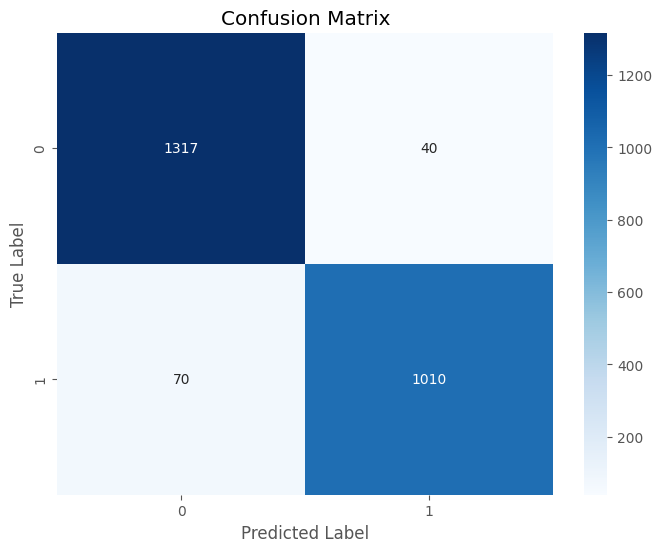

In [47]:
models_trained = {}
best_params = {}
evaluates = {}
for name, model in models.items():
    print(f"Training {model}...")
    # Train model
    model_trained = train_model(model, param_grids[name], verbose=0)
    # Evaluate the model
    acc, prec, rec, roc_auc = evaluate_metrics(model_trained, X_test, y_test)

    models_trained[name] = model_trained
    best_params[name] = model_trained.best_params_
    evaluates[name] = [acc, prec, rec, roc_auc]

In [48]:
pd.DataFrame(evaluates, index=["accuracy", "precision", "recall", "roc_auc"])

,lr,dt,rf,xgb
accuracy,0.790316,0.956504,0.959376,0.954863
precision,0.774349,0.968269,0.971182,0.961905
recall,0.743519,0.932407,0.936111,0.935185
roc_auc,0.863892,0.958570,0.952712,0.955324


Berdasarkan dataframe tersebut, terlihat bahwa ketiga model (Decision Tree, Random Forest, XGBoost) memiliki nilai evaluasi yang cukup baik. Sedangkan Logistic Regression yang sensitif terhadap skala fitur mendapatkan hasil yang kurang baik.

> Sebagai evaluasi, model dapat ditraining kembali menggunakan fitur yang distandarisasi.

### Kesimpulan

**Performa Model:**

- `Random Forest` menunjukkan performa terbaik di antara semua model dengan skor tertinggi pada `Accuracy` (0.9594) dan - `Precision` (0.9712). Ini menunjukkan bahwa Random Forest memiliki kemampuan yang sangat baik dalam memprediksi penyelesaian kursus dengan tingkat akurasi yang konsisten di berbagai metrik evaluasi.
- `Decision Tree` dan `XGBoost` juga menunjukkan performa yang sangat baik dan kompetitif dengan Random Forest, dengan skor yang sangat dekat. Kedua model ini juga dapat dipertimbangkan sebagai alternatif yang kuat.
- `Logistic Regression` menunjukkan performa yang lebih rendah dibandingkan dengan model lain. Meskipun akurasi pada `ROC AUC` cukup tinggi (0.8639), performa keseluruhan lebih rendah.

**Pemilihan Model untuk Implementasi:**

- Berdasarkan hasil evaluasi, `Random Forest` adalah model yang direkomendasikan untuk implementasi karena konsistensi dan performa tinggi di berbagai metrik evaluasi.
- `Decision Tree` dan `XGBoost` juga dapat dipertimbangkan sebagai alternatif, terutama jika terdapat pertimbangan lain seperti interpretabilitas model atau kecepatan prediksi.

**Interpretasi dan Tindakan Lanjutan:**

- Hasil ini menunjukkan bahwa model ensemble seperti `Random Forest` dan `XGBoost` lebih mampu menangkap kompleksitas data dibandingkan model linear seperti `Logistic Regression`.
- Langkah selanjutnya adalah melakukan fine-tuning hyperparameter untuk `Random Forest` dan `XGBoost` untuk lebih meningkatkan performa model.
- Implementasi model terpilih ke dalam sistem produksi untuk memprediksi peserta yang berisiko tidak menyelesaikan kursus dan merancang intervensi yang sesuai untuk meningkatkan tingkat penyelesaian kursus.